In [216]:
import os
import numpy as np
from os.path import isfile, join
from os import listdir, path
import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import json
import cv2
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D,AveragePooling2D, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam, Adadelta

In [217]:
def configure_annotations(train_annotations_filename, val_annotations_filename):
    with open(train_annotations_filename) as f:
        train_annotations_filename = json.load(f)
    with open(val_annotations_filename) as f:
        val_annotations_filename = json.load(f)
    
    return train_annotations_filename, val_annotations_filename

In [218]:
train_annotations_filename, val_annotations_filename = configure_annotations('train_ann.json', 'validation_ann.json')

In [219]:
#Size size coeff for reduce training time (also I assume what we can convert coordinates back)
# note:
#  when I calculate and set width and height except points I got better accuracy
def congigure_box(box, size_coeff):
    width = box[2] - box[0]
    height = box[3] - box[1]
    box[2] = width
    box[3] = height
    
    box[0] *= size_coeff
    box[1] *= size_coeff
    box[2] *= size_coeff
    box[3] *= size_coeff
    return box

In [220]:
def get_train_dataset_and_val_dataset(dirName):
    image_names = listdir(dirName)
    train_X = []
    train_Y = []
    test_X = []
    test_Y = []
    for filename in image_names:
        if filename.endswith('.png'):
            image = mpimg.imread(path.join(os.getcwd() + "/rect_images/" + filename))
            gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            size_coeff = 0.2
            new_size = (int(gray_image.shape[1] * size_coeff), int(gray_image.shape[0] * size_coeff))
            gray_image = cv2.resize(gray_image, new_size)
            
            for train_ann in train_annotations_filename:
                if train_ann['fname'] == filename:
                    box = train_ann['box']
                    box = congigure_box(box, size_coeff)

                    train_X.append(gray_image)
                    train_Y.append(np.array(box, dtype=float))
                    
            for val_ann in val_annotations_filename:
                if val_ann['fname'] == filename:
                    box = val_ann['box']
                    box = congigure_box(box, size_coeff)
                    
                    test_X.append(gray_image)
                    test_Y.append(np.array(box, dtype=float))
                    
    return np.array(train_X), np.array(train_Y), np.array(test_X), np.array(test_Y)

In [221]:
train_X, train_Y, test_X, test_Y = get_train_dataset_and_val_dataset("rect_images")

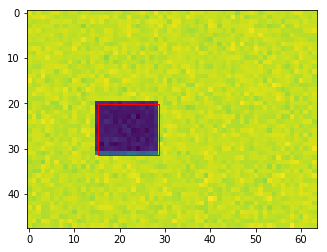

In [222]:
def draw_image_and_box(test_image, test_box):
    rect = matplotlib.patches.Rectangle((test_box[0],test_box[1]), test_box[2], test_box[3], linewidth=1,edgecolor='r',facecolor='none')
    plt.imshow(test_image)
    plt.gca().add_patch(rect)
    
test_index = 4
test_image, test_box = train_X[test_index], train_Y[test_index]
draw_image_and_box(test_image, test_box)

In [223]:
#Normalization step
# links for future:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/normalize
norm_train_X = (train_X - np.min(train_X)) / (np.max(train_X) - np.min(train_X))
norm_test_X = (test_X - np.min(test_X)) / (np.max(test_X) - np.min(test_X))
norm_train_Y = (train_Y - np.min(train_Y)) / (np.max(train_Y) - np.min(train_Y))
norm_test_Y = (test_Y - np.min(test_Y)) / (np.max(test_Y) - np.min(test_Y))

In [224]:
def addConvNormPoolDropLayer(model, channels, kernel_size, input_shape, max_pool, dropout):
    model.add(Conv2D(channels, kernel_size=kernel_size, activation='relu', input_shape = input_shape))
    model.add(BatchNormalization())
    if max_pool > 0:
            model.add(AveragePooling2D(max_pool))
    if dropout > 0:
        model.add(Dropout(0.2))

In [232]:
width = train_X[1].shape[1]
height = train_X[0].shape[0]

norm_train_X = norm_train_X.reshape(train_X.shape[0], height, width, 1)
norm_test_X = norm_test_X.reshape(test_X.shape[0], height, width, 1)
norm_train_Y = norm_train_Y.reshape(train_X.shape[0], 4)
norm_test_Y = norm_test_Y.reshape(test_X.shape[0], 4)

model = Sequential()
#add model layers
addConvNormPoolDropLayer(model, 8, 4, (height, width, 1), 4, 0)
#addConvNormPoolDropLayer(model, 8, 4, (height, width, 1), 2, 0)
addConvNormPoolDropLayer(model, 4, 4, (height, width, 1), 0, 0.2)

model.add(Flatten())
model.add(Dense(50))
model.add(Dense(4))

#sgd stuck in minumun after 4 epochs to 100 (calculation not continued) val loss 0.0283 with 2 convlnormpoollayer
#adadelta - val loss after 150 epoch 0.066  with 2 convlnormpoollayer 
#adam 0.0052 -  with 2 convlnormpoollayer (with 3 layers same)
#RMSProp - 0.0289 stuck after 4 to 100 epochs  with 2 convlnormpoollayer with 3 layers 0.0062

#links for future:
# https://www.quora.com/What-are-differences-between-update-rules-like-AdaDelta-RMSProp-AdaGrad-and-AdaM
# https://www.youtube.com/watch?v=qAVZd6dHxPA
# http://www.bcl.hamilton.ie/~barak/papers/nips91-descent.pdf
model.compile('adam', 'mse')
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_88 (Conv2D)           (None, 45, 61, 8)         136       
_________________________________________________________________
batch_normalization_86 (Batc (None, 45, 61, 8)         32        
_________________________________________________________________
average_pooling2d_52 (Averag (None, 11, 15, 8)         0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 8, 12, 4)          516       
_________________________________________________________________
batch_normalization_87 (Batc (None, 8, 12, 4)          16        
_________________________________________________________________
dropout_33 (Dropout)         (None, 8, 12, 4)          0         
_________________________________________________________________
flatten_33 (Flatten)         (None, 384)               0         
__________

In [233]:
history = model.fit(norm_train_X, norm_train_Y, epochs=150, shuffle=True, validation_data=(norm_test_X, norm_test_Y), verbose=2, batch_size=10)

Train on 2699 samples, validate on 301 samples
Epoch 1/150
 - 6s - loss: 0.6565 - val_loss: 0.0371
Epoch 2/150
 - 4s - loss: 0.1623 - val_loss: 0.0358
Epoch 3/150
 - 4s - loss: 0.0716 - val_loss: 0.0405
Epoch 4/150
 - 4s - loss: 0.0461 - val_loss: 0.0359
Epoch 5/150
 - 4s - loss: 0.0384 - val_loss: 0.0335
Epoch 6/150
 - 4s - loss: 0.0355 - val_loss: 0.0331
Epoch 7/150
 - 4s - loss: 0.0342 - val_loss: 0.0324
Epoch 8/150
 - 4s - loss: 0.0357 - val_loss: 0.0453
Epoch 9/150
 - 4s - loss: 0.0338 - val_loss: 0.0313
Epoch 10/150
 - 4s - loss: 0.0337 - val_loss: 0.0406
Epoch 11/150
 - 4s - loss: 0.0260 - val_loss: 0.0216
Epoch 12/150
 - 4s - loss: 0.0203 - val_loss: 0.0197
Epoch 13/150
 - 4s - loss: 0.0207 - val_loss: 0.0228
Epoch 14/150
 - 4s - loss: 0.0172 - val_loss: 0.0188
Epoch 15/150
 - 4s - loss: 0.0197 - val_loss: 0.0325
Epoch 16/150
 - 4s - loss: 0.0164 - val_loss: 0.0219
Epoch 17/150
 - 4s - loss: 0.0150 - val_loss: 0.0487
Epoch 18/150
 - 4s - loss: 0.0139 - val_loss: 0.0142
Epoch 19

['loss', 'val_loss']


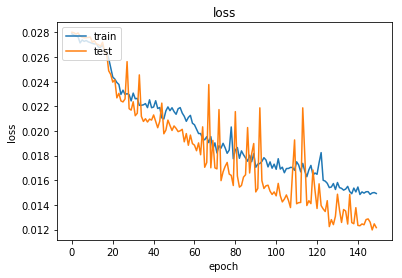

In [93]:
# summarize history for accuracy
# sgd plot (now )


# for the future: 
# make plots for all optimizers
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [234]:
pred_y = model.predict(norm_test_X)
denormalized_pred_y = pred_y * (np.max(test_Y) - np.min(test_Y)) + np.min(test_Y)
testIndex = 2
print(denormalized_pred_y[testIndex])
print(test_Y[testIndex])

[13.591768  19.557156  15.751869   6.2410436]
[15.  19.  17.2  4. ]


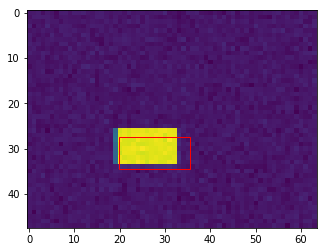

In [241]:
test_index = 5
test_image, test_box = test_X[test_index], denormalized_pred_y[test_index]
draw_image_and_box(test_image, test_box)

In [238]:
def IOU(bbox1, bbox2):
    print(bbox1)
    print(bbox2)


    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:
        return 0.
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U


summed_IOU = 0.
for pred_bbox, test_bbox in zip(denormalized_pred_y.reshape(-1, 4), test_Y.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
    
    
mean_IOU = summed_IOU / len(denormalized_pred_y)
print(mean_IOU)

[47.536854   7.933871  12.122978   6.2318745]
[44.6 11.6 17.2  2. ]
[37.609814 16.009497  9.134184  8.371807]
[38.4 14.  15.  10.8]
[13.591768  19.557156  15.751869   6.2410436]
[15.  19.  17.2  4. ]
[ 8.417952   3.1097257 12.763382  11.135214 ]
[10.4  2.8 16.2 16.2]
[ 5.2585483 18.923553  21.804165  10.731263 ]
[16.4 14.4 19.  14.2]
[19.800795  27.445871  15.695783   7.0482273]
[19.6 26.  13.4  8. ]
[ 1.002657  34.011917   6.9296627  9.33801  ]
[ 2.2 29.   7.2 15.2]
[29.884365 21.176357  7.219741  7.01013 ]
[28.4 26.6 17.2 16.8]
[41.438263 34.35424  16.807682 10.098839]
[37.  28.  16.8 13.6]
[ 2.063723  9.884649 11.889727  6.638493]
[ 1.  14.8 18.6  2.2]
[50.69351  30.480068  7.31235  12.225465]
[47.4 27.4  5.4 13. ]
[10.775352  27.097591  21.015156   7.8165555]
[18.4 19.4 16.2  9.8]
[32.443226 29.187637 12.468033  9.030329]
[28.6 16.4 18.  19.2]
[ 3.4266536 35.024986   7.6405635  5.6439524]
[ 1.8 30.8  6.8  3.4]
[11.718442 13.924585 10.654545  6.05754 ]
[14.8 15.8  6.6  2.8]
[46.6857

In [203]:
def plot_conv_weights(model, layer_index):
    W = model.get_layer(index=layer_index).get_weights()
    print(W[0])
#     print(W[1])
#     print(W[2])

In [204]:
plot_conv_weights(model, 0)

[[[[-2.5430208e-01  3.7061088e-02 -1.3132846e-01 -3.1998396e-02
    -5.2370620e-01  4.5284462e-01 -3.8831696e-01 -4.0792277e-01]]

  [[-2.7172396e-01 -9.7845376e-02 -2.4474150e-01 -1.0911063e-01
    -2.5175723e-01  2.3433945e-01  3.2934744e-02 -8.2198270e-02]]

  [[-1.3269736e-01 -6.4191282e-02  1.2888756e-02 -1.9510233e-01
    -1.7815378e-01  4.2342940e-01  2.7840227e-01 -6.5781809e-02]]

  [[-8.8463068e-02  4.5502555e-04  1.2235879e-01 -3.9306324e-02
    -1.1299506e-01  2.5797206e-01  1.0139600e-01  9.0767853e-02]]]


 [[[-1.6649874e-01 -1.3022689e-02 -2.5688112e-01 -2.7703813e-01
    -1.4142118e-01  1.6058746e-01 -3.1194970e-01 -1.5999159e-01]]

  [[-2.6608175e-01  1.0183186e-01 -1.3929486e-01 -2.1767023e-01
    -3.7101200e-01 -2.6147515e-03 -6.9520645e-02  2.8200129e-02]]

  [[-5.8621276e-02 -7.1787812e-02 -4.3283239e-02 -9.0690799e-02
     1.3059257e-01  8.6287305e-02  2.5628376e-01 -1.5870553e-01]]

  [[-3.3750940e-02 -2.1250656e-01 -1.3268064e-01 -4.2993709e-02
     1.5818009e-0

# 